## Importing packages

In [1]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import torchvision
import numpy as np
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from torchvision.transforms.autoaugment import AutoAugmentPolicy
import time
import os
import cv2
from PIL import Image
import random
import pandas as pd
import scipy.misc as misc


## Using GPU for PyTorch

In [2]:
# determine the device to be used for training and evaluation
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "mps" else False
print(f'Current device is {DEVICE}')



Current device is mps


## Configuration parameters for segmentation

In [3]:
# base path of the dataset
#DATASET_PATH = "OneDrive/Dokumenty/SkinLesionSegmentation/ham1000-segmentation-and-classification/"
DATASET_PATH = "ham1000-segmentation-and-classification"
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images/")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks/")

# define the test split
TEST_SPLIT = 0.15

# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64

# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = "output"

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])


## Dataset

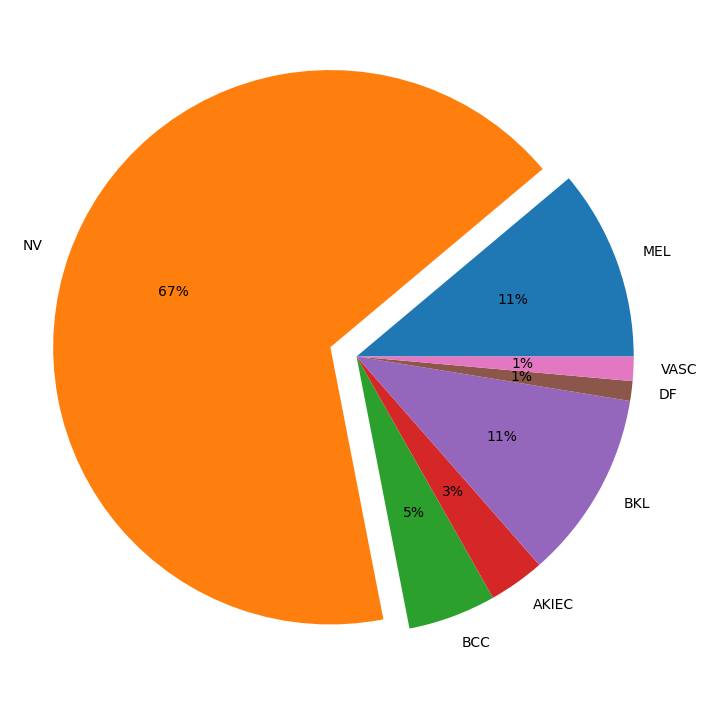

In [4]:
GT = pd.read_csv('ham1000-segmentation-and-classification//GroundTruth.csv')
gt = GT.sum().to_frame().reset_index().drop(0)
gt.columns = ['toc', 'sum']

plt.figure(figsize=(15,9))
explode = [0, 0.1, 0, 0, 0, 0, 0]
plt.pie(gt['sum'], labels=gt['toc'],explode=explode, autopct='%.0f%%')
plt.show()


## Segmentation Dataset Class

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        self.augmentations = augmentations
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        # return a tuple of the image and its mask
        return (image,mask)
    

# Building Our U-Net Model in PyTorch

In [6]:
class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))
    

In [7]:
class Encoder(Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(2)
        
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
            # return the list containing the intermediate outputs
        return blockOutputs                        
                                     

In [8]:
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
             for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])
        
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
            # return the final decoder output
        return x
      
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures
    

In [9]:
class UNet(Module):
    def __init__(self,encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16), 
                 nbClasses=1, retainDim=True, 
                 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        
        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
            
        # return the segmentation map    
        return map
        

## Metrics

In [10]:
#PyTorch
class DiceBCELoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        print(f'BCE {BCE}')
        print(f'DICE {dice_loss}')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

## Preparing Data and Model

In [11]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
    test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()


[INFO] saving testing image paths...


In [12]:
# define transformations
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)),
    torchvision.transforms.ToTensor()])
    
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=0)
testLoader = DataLoader(testDS, shuffle=False,batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=0)


[INFO] found 8512 examples in the training set...
[INFO] found 1503 examples in the test set...


In [13]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = DiceBCELoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}
next(unet.parameters()).is_cuda


False

## Sprawdzić funkcję do optymalizacji

In [14]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    diceScoreTrain = 0
    diceScoreTest = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
        diceScoreTrain += (2 * (x * y).sum()) / (2 * (x * y).sum()+ ((x*y)<1).sum())
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
            diceScoreTest += (2 * (x * y).sum()) / (2 * (x * y).sum()+ ((x*y)<1).sum())
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    avgDiceTrain = diceScoreTrain / trainSteps
    avgDiceTest = diceScoreTest / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    print(f"Train DS: {avgDiceTrain} Test DS: {avgDiceTest}")
    # display the total time needed to perform the training
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
    

[INFO] training the network...


  0%|                                                    | 0/40 [00:00<?, ?it/s]

BCE 0.6986289620399475
DICE 0.6262427568435669
BCE 0.6894890666007996
DICE 0.6692363619804382
BCE 0.6747655868530273
DICE 0.6843537092208862
BCE 0.6603083610534668
DICE 0.6484729647636414
BCE 0.634118914604187
DICE 0.6642316579818726
BCE 0.6155762672424316
DICE 0.6347442865371704
BCE 0.5495041608810425
DICE 0.6882373094558716
BCE 0.5812563896179199
DICE 0.6591025590896606
BCE 0.5345988869667053
DICE 0.6855373382568359
BCE 0.491653174161911
DICE 0.7105107307434082
BCE 0.4990675449371338
DICE 0.7165583372116089
BCE 0.5295279026031494
DICE 0.6949743032455444
BCE 0.4750550091266632
DICE 0.6857155561447144
BCE 0.44499415159225464
DICE 0.7111374139785767
BCE 0.5352245569229126
DICE 0.6744827032089233
BCE 0.4627690017223358
DICE 0.6728599071502686
BCE 0.48443228006362915
DICE 0.669841468334198
BCE 0.505230188369751
DICE 0.637047290802002
BCE 0.4801086187362671
DICE 0.6285611391067505
BCE 0.48536694049835205
DICE 0.6469227075576782
BCE 0.5008275508880615
DICE 0.609054684638977
BCE 0.4226387739

  2%|█                                           | 1/40 [01:13<47:45, 73.47s/it]

BCE 0.36789166927337646
DICE 0.30668169260025024
[INFO] EPOCH: 1/40
Train loss: 0.870781, Test loss: 0.7638
Train DS: 0.20904429256916046 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 73.72s
BCE 0.4467151165008545
DICE 0.3724682331085205
BCE 0.3834821581840515
DICE 0.38548338413238525
BCE 0.3860350549221039
DICE 0.3572034239768982
BCE 0.40147703886032104
DICE 0.34620338678359985
BCE 0.32398882508277893
DICE 0.3543502688407898
BCE 0.3828318119049072
DICE 0.3584461808204651
BCE 0.2873538136482239
DICE 0.35292738676071167
BCE 0.3692595064640045
DICE 0.3025076389312744
BCE 0.3813124895095825
DICE 0.347817063331604
BCE 0.31416404247283936
DICE 0.3474486470222473
BCE 0.41612595319747925
DICE 0.3683823347091675
BCE 0.36450737714767456
DICE 0.35456663370132446
BCE 0.35138583183288574
DICE 0.3106083273887634
BCE 0.4403139352798462
DICE 0.37910276651382446
BCE 0.3156699538230896
DICE 0.30088376998901367
BCE 0.36599522829055786
DICE 0.3253839612007141
BCE 0.385983973741

  5%|██▏                                         | 2/40 [02:22<44:52, 70.86s/it]

BCE 0.3573994040489197
DICE 0.3066520094871521
[INFO] EPOCH: 2/40
Train loss: 0.716374, Test loss: 0.7251
Train DS: 0.20904847979545593 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 142.75s
BCE 0.3528923988342285
DICE 0.346687376499176
BCE 0.37346675992012024
DICE 0.35095083713531494
BCE 0.3253014087677002
DICE 0.33094269037246704
BCE 0.3734101951122284
DICE 0.36584311723709106
BCE 0.37304943799972534
DICE 0.3390076756477356
BCE 0.36260080337524414
DICE 0.3347201347351074
BCE 0.4141174852848053
DICE 0.36910170316696167
BCE 0.3876233696937561
DICE 0.33194488286972046
BCE 0.3158918619155884
DICE 0.3550909757614136
BCE 0.3189276456832886
DICE 0.363910973072052
BCE 0.3357643187046051
DICE 0.34184712171554565
BCE 0.25490832328796387
DICE 0.3232090473175049
BCE 0.29081231355667114
DICE 0.3091058135032654
BCE 0.4421283006668091
DICE 0.32588404417037964
BCE 0.32536280155181885
DICE 0.3115253448486328
BCE 0.3646980822086334
DICE 0.3139563798904419
BCE 0.32913279533386

  8%|███▎                                        | 3/40 [03:32<43:27, 70.47s/it]

BCE 0.31184181571006775
DICE 0.2710005044937134
[INFO] EPOCH: 3/40
Train loss: 0.668284, Test loss: 0.6559
Train DS: 0.20905561745166779 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 212.76s
BCE 0.33308184146881104
DICE 0.27972012758255005
BCE 0.34995582699775696
DICE 0.31502437591552734
BCE 0.2565739154815674
DICE 0.2957882285118103
BCE 0.31670624017715454
DICE 0.2838931679725647
BCE 0.32505226135253906
DICE 0.34847384691238403
BCE 0.3118237257003784
DICE 0.27815115451812744
BCE 0.37140440940856934
DICE 0.30315130949020386
BCE 0.2662084698677063
DICE 0.25082260370254517
BCE 0.3437555730342865
DICE 0.299869179725647
BCE 0.3808044195175171
DICE 0.31799131631851196
BCE 0.2946549654006958
DICE 0.26984041929244995
BCE 0.4149509370326996
DICE 0.3729970455169678
BCE 0.3153287172317505
DICE 0.3260839581489563
BCE 0.3338262438774109
DICE 0.30717939138412476
BCE 0.32973527908325195
DICE 0.3347991704940796
BCE 0.3886144757270813
DICE 0.34587353467941284
BCE 0.349429428

 10%|████▍                                       | 4/40 [04:42<42:11, 70.32s/it]

BCE 0.3567122220993042
DICE 0.2941285967826843
[INFO] EPOCH: 4/40
Train loss: 0.642417, Test loss: 0.6705
Train DS: 0.2090829312801361 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 282.85s
BCE 0.4246745705604553
DICE 0.3912186026573181
BCE 0.3705150783061981
DICE 0.28409916162490845
BCE 0.3236428201198578
DICE 0.2739947438240051
BCE 0.35516512393951416
DICE 0.30721116065979004
BCE 0.2794656753540039
DICE 0.3200807571411133
BCE 0.33110159635543823
DICE 0.31399792432785034
BCE 0.4079263508319855
DICE 0.3386167883872986
BCE 0.3159337639808655
DICE 0.29680514335632324
BCE 0.3308466374874115
DICE 0.31095296144485474
BCE 0.24232923984527588
DICE 0.25032299757003784
BCE 0.32610785961151123
DICE 0.3007323741912842
BCE 0.30617302656173706
DICE 0.2902776002883911
BCE 0.3264138698577881
DICE 0.3346344232559204
BCE 0.269092857837677
DICE 0.27524566650390625
BCE 0.35304901003837585
DICE 0.3080381751060486
BCE 0.28619253635406494
DICE 0.2978748083114624
BCE 0.3236520290374

 12%|█████▌                                      | 5/40 [05:52<40:59, 70.27s/it]

BCE 0.2886000871658325
DICE 0.25671452283859253
[INFO] EPOCH: 5/40
Train loss: 0.600899, Test loss: 0.6032
Train DS: 0.20914947986602783 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 353.03s
BCE 0.3524284362792969
DICE 0.2905023694038391
BCE 0.26514479517936707
DICE 0.2877779006958008
BCE 0.3264210522174835
DICE 0.27635788917541504
BCE 0.3131254017353058
DICE 0.32035982608795166
BCE 0.356714129447937
DICE 0.3332485556602478
BCE 0.26567888259887695
DICE 0.26624804735183716
BCE 0.27166295051574707
DICE 0.2666226029396057
BCE 0.28998714685440063
DICE 0.2821733355522156
BCE 0.2137351930141449
DICE 0.2185627818107605
BCE 0.3109162449836731
DICE 0.276547372341156
BCE 0.32099539041519165
DICE 0.3092133402824402
BCE 0.309647798538208
DICE 0.29497581720352173
BCE 0.3482736051082611
DICE 0.2942291498184204
BCE 0.27712947130203247
DICE 0.2422783374786377
BCE 0.24990977346897125
DICE 0.27393049001693726
BCE 0.2977566421031952
DICE 0.2998389005661011
BCE 0.354184269905090

 15%|██████▌                                     | 6/40 [07:02<39:46, 70.20s/it]

BCE 0.2751995027065277
DICE 0.2512022852897644
[INFO] EPOCH: 6/40
Train loss: 0.588763, Test loss: 0.5956
Train DS: 0.2091386467218399 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 423.11s
BCE 0.3712686598300934
DICE 0.32011014223098755
BCE 0.2889690697193146
DICE 0.3076150417327881
BCE 0.2410183548927307
DICE 0.29674261808395386
BCE 0.3118933439254761
DICE 0.289247989654541
BCE 0.2667321264743805
DICE 0.294887900352478
BCE 0.30177491903305054
DICE 0.29061996936798096
BCE 0.25942105054855347
DICE 0.26630181074142456
BCE 0.25034618377685547
DICE 0.25381314754486084
BCE 0.25293999910354614
DICE 0.2522696256637573
BCE 0.28609567880630493
DICE 0.2560352683067322
BCE 0.23117595911026
DICE 0.21319782733917236
BCE 0.3024698495864868
DICE 0.26959627866744995
BCE 0.382465660572052
DICE 0.2980797290802002
BCE 0.2591736912727356
DICE 0.2750457525253296
BCE 0.30015337467193604
DICE 0.27725619077682495
BCE 0.2913142442703247
DICE 0.28323328495025635
BCE 0.2617142796516418

 18%|███████▋                                    | 7/40 [08:12<38:35, 70.16s/it]

BCE 0.2852112650871277
DICE 0.24908286333084106
[INFO] EPOCH: 7/40
Train loss: 0.560799, Test loss: 0.5663
Train DS: 0.2090134620666504 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 493.19s
BCE 0.25230228900909424
DICE 0.2598612904548645
BCE 0.24106982350349426
DICE 0.257759690284729
BCE 0.19957949221134186
DICE 0.2707957625389099
BCE 0.2623395323753357
DICE 0.2768281102180481
BCE 0.24845632910728455
DICE 0.2838023900985718
BCE 0.28971439599990845
DICE 0.24787253141403198
BCE 0.33248209953308105
DICE 0.3128662109375
BCE 0.30584239959716797
DICE 0.25599437952041626
BCE 0.2527618110179901
DICE 0.25133687257766724
BCE 0.22678962349891663
DICE 0.2637026309967041
BCE 0.3539162576198578
DICE 0.30804020166397095
BCE 0.2290288507938385
DICE 0.2500527501106262
BCE 0.21971717476844788
DICE 0.23085522651672363
BCE 0.27476367354393005
DICE 0.28748124837875366
BCE 0.2583128809928894
DICE 0.26764118671417236
BCE 0.2879149913787842
DICE 0.26043516397476196
BCE 0.30205923318

 20%|████████▊                                   | 8/40 [09:23<37:26, 70.21s/it]

BCE 0.30625805258750916
DICE 0.25301212072372437
[INFO] EPOCH: 8/40
Train loss: 0.549167, Test loss: 0.5656
Train DS: 0.20911023020744324 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 563.50s
BCE 0.29872065782546997
DICE 0.27675265073776245
BCE 0.20006968080997467
DICE 0.24783164262771606
BCE 0.3002561330795288
DICE 0.25106120109558105
BCE 0.35687291622161865
DICE 0.2850908637046814
BCE 0.32223808765411377
DICE 0.24379897117614746
BCE 0.29111146926879883
DICE 0.2713543176651001
BCE 0.3260783553123474
DICE 0.26087498664855957
BCE 0.2869129180908203
DICE 0.27128738164901733
BCE 0.255252480506897
DICE 0.2768515944480896
BCE 0.2669922113418579
DICE 0.28735965490341187
BCE 0.2993209958076477
DICE 0.30076664686203003
BCE 0.2500258982181549
DICE 0.25113898515701294
BCE 0.28015726804733276
DICE 0.27983325719833374
BCE 0.26670998334884644
DICE 0.270416259765625
BCE 0.3052598834037781
DICE 0.2734447121620178
BCE 0.2608763873577118
DICE 0.253508985042572
BCE 0.279095113

 22%|█████████▉                                  | 9/40 [10:33<36:13, 70.10s/it]

BCE 0.2913670539855957
DICE 0.2382914423942566
[INFO] EPOCH: 9/40
Train loss: 0.549726, Test loss: 0.5641
Train DS: 0.20913946628570557 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 633.36s
BCE 0.309882789850235
DICE 0.24774032831192017
BCE 0.330283522605896
DICE 0.27589958906173706
BCE 0.2646355628967285
DICE 0.24646669626235962
BCE 0.27905815839767456
DICE 0.26417046785354614
BCE 0.29646220803260803
DICE 0.2740553021430969
BCE 0.30954915285110474
DICE 0.26970207691192627
BCE 0.24498841166496277
DICE 0.29256826639175415
BCE 0.2622954845428467
DICE 0.24941718578338623
BCE 0.26786428689956665
DICE 0.2561570405960083
BCE 0.23608903586864471
DICE 0.24585986137390137
BCE 0.30984461307525635
DICE 0.2632904648780823
BCE 0.23179388046264648
DICE 0.2669524550437927
BCE 0.22632279992103577
DICE 0.23846900463104248
BCE 0.3403012752532959
DICE 0.28609728813171387
BCE 0.2310669720172882
DICE 0.21265697479248047
BCE 0.3060391843318939
DICE 0.2663571238517761
BCE 0.2639124

 25%|██████████▊                                | 10/40 [11:43<35:02, 70.07s/it]

BCE 0.3001328110694885
DICE 0.23646986484527588
[INFO] EPOCH: 10/40
Train loss: 0.537257, Test loss: 0.5597
Train DS: 0.209041565656662 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 703.37s
BCE 0.29941245913505554
DICE 0.2561010718345642
BCE 0.3116024434566498
DICE 0.2837240695953369
BCE 0.2706851363182068
DICE 0.2582055330276489
BCE 0.2809905409812927
DICE 0.22965925931930542
BCE 0.2710728049278259
DICE 0.2579839825630188
BCE 0.29225069284439087
DICE 0.26240313053131104
BCE 0.3096940517425537
DICE 0.29375404119491577
BCE 0.2770894765853882
DICE 0.24121516942977905
BCE 0.22432959079742432
DICE 0.23149174451828003
BCE 0.2621656358242035
DICE 0.24529534578323364
BCE 0.22204899787902832
DICE 0.23713314533233643
BCE 0.2533836364746094
DICE 0.24783611297607422
BCE 0.22479048371315002
DICE 0.24716675281524658
BCE 0.3562139868736267
DICE 0.27968424558639526
BCE 0.28847748041152954
DICE 0.24237662553787231
BCE 0.27346116304397583
DICE 0.23692190647125244
BCE 0.256258

 28%|███████████▊                               | 11/40 [12:52<33:50, 70.00s/it]

BCE 0.2764427661895752
DICE 0.2204430103302002
[INFO] EPOCH: 11/40
Train loss: 0.531909, Test loss: 0.5520
Train DS: 0.20915012061595917 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 773.20s
BCE 0.2818455100059509
DICE 0.23658889532089233
BCE 0.2517705261707306
DICE 0.25447356700897217
BCE 0.343727171421051
DICE 0.28399842977523804
BCE 0.2495799958705902
DICE 0.24268513917922974
BCE 0.2856804132461548
DICE 0.29347604513168335
BCE 0.3608900308609009
DICE 0.3086901307106018
BCE 0.2859939932823181
DICE 0.26703721284866333
BCE 0.2188889980316162
DICE 0.21603351831436157
BCE 0.20326462388038635
DICE 0.24831461906433105
BCE 0.2389719933271408
DICE 0.28701353073120117
BCE 0.23654791712760925
DICE 0.2338849902153015
BCE 0.28362369537353516
DICE 0.23794811964035034
BCE 0.2621462047100067
DICE 0.2560268044471741
BCE 0.29091158509254456
DICE 0.20533597469329834
BCE 0.2867409586906433
DICE 0.2266218662261963
BCE 0.2797110974788666
DICE 0.2218131422996521
BCE 0.2777286171

 30%|████████████▉                              | 12/40 [14:02<32:40, 70.01s/it]

BCE 0.2788074016571045
DICE 0.22432279586791992
[INFO] EPOCH: 12/40
Train loss: 0.521223, Test loss: 0.5477
Train DS: 0.20904114842414856 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 843.23s
BCE 0.21598297357559204
DICE 0.23895061016082764
BCE 0.2068929225206375
DICE 0.23757976293563843
BCE 0.27929604053497314
DICE 0.2586020231246948
BCE 0.2527833878993988
DICE 0.2330772876739502
BCE 0.28579163551330566
DICE 0.22958260774612427
BCE 0.27144700288772583
DICE 0.24286621809005737
BCE 0.2880095839500427
DICE 0.2500351071357727
BCE 0.25306761264801025
DICE 0.2100645899772644
BCE 0.3255731761455536
DICE 0.2507684826850891
BCE 0.2602652907371521
DICE 0.21888816356658936
BCE 0.27022692561149597
DICE 0.25682544708251953
BCE 0.24148015677928925
DICE 0.25408536195755005
BCE 0.2598571181297302
DICE 0.27946579456329346
BCE 0.2819522023200989
DICE 0.30997222661972046
BCE 0.26454615592956543
DICE 0.25961464643478394
BCE 0.2838541865348816
DICE 0.2712591886520386
BCE 0.22517

 32%|█████████████▉                             | 13/40 [15:12<31:29, 70.00s/it]

BCE 0.26543137431144714
DICE 0.2383241057395935
[INFO] EPOCH: 13/40
Train loss: 0.518256, Test loss: 0.5319
Train DS: 0.20910240709781647 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 913.20s
BCE 0.27833232283592224
DICE 0.2651349902153015
BCE 0.2731098532676697
DICE 0.23960143327713013
BCE 0.24180470407009125
DICE 0.22758328914642334
BCE 0.27819445729255676
DICE 0.2657341957092285
BCE 0.23692578077316284
DICE 0.247874915599823
BCE 0.26952195167541504
DICE 0.25667792558670044
BCE 0.2856016159057617
DICE 0.23757022619247437
BCE 0.31540554761886597
DICE 0.23693132400512695
BCE 0.24329423904418945
DICE 0.22920584678649902
BCE 0.275509238243103
DICE 0.2553805112838745
BCE 0.28822991251945496
DICE 0.2931310534477234
BCE 0.24512338638305664
DICE 0.2287694811820984
BCE 0.27313047647476196
DICE 0.2679412364959717
BCE 0.25326007604599
DICE 0.2500900626182556
BCE 0.24314475059509277
DICE 0.24658918380737305
BCE 0.23389069736003876
DICE 0.2266743779182434
BCE 0.23923733

 35%|███████████████                            | 14/40 [16:23<30:26, 70.24s/it]

BCE 0.28012365102767944
DICE 0.2284529209136963
[INFO] EPOCH: 14/40
Train loss: 0.511739, Test loss: 0.5273
Train DS: 0.2091129571199417 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 984.01s
BCE 0.29091280698776245
DICE 0.2613126039505005
BCE 0.2496960163116455
DICE 0.23823660612106323
BCE 0.24968111515045166
DICE 0.2489965558052063
BCE 0.28067636489868164
DICE 0.25381702184677124
BCE 0.26399490237236023
DICE 0.28633183240890503
BCE 0.3109463155269623
DICE 0.2598384618759155
BCE 0.22767946124076843
DICE 0.24973011016845703
BCE 0.2672704756259918
DICE 0.2272753119468689
BCE 0.2391490340232849
DICE 0.21324318647384644
BCE 0.22278329730033875
DICE 0.2300853729248047
BCE 0.2705288827419281
DICE 0.22721171379089355
BCE 0.2617216110229492
DICE 0.24870383739471436
BCE 0.2572469711303711
DICE 0.20612585544586182
BCE 0.2982330918312073
DICE 0.24810791015625
BCE 0.26304125785827637
DICE 0.231828510761261
BCE 0.32245320081710815
DICE 0.26188182830810547
BCE 0.2289780080

 38%|████████████████▏                          | 15/40 [17:35<29:30, 70.83s/it]

BCE 0.287958562374115
DICE 0.23220378160476685
[INFO] EPOCH: 15/40
Train loss: 0.513765, Test loss: 0.5530
Train DS: 0.2091245800256729 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1056.20s
BCE 0.22323322296142578
DICE 0.2299221158027649
BCE 0.2586679756641388
DICE 0.2657783627510071
BCE 0.2600691318511963
DICE 0.2313668131828308
BCE 0.29014989733695984
DICE 0.25148701667785645
BCE 0.2706007659435272
DICE 0.2291017770767212
BCE 0.2730339765548706
DICE 0.2555084824562073
BCE 0.24002774059772491
DICE 0.2523149251937866
BCE 0.2858644127845764
DICE 0.2681944966316223
BCE 0.2277449369430542
DICE 0.25639116764068604
BCE 0.18433938920497894
DICE 0.20659512281417847
BCE 0.22964705526828766
DICE 0.26190614700317383
BCE 0.2776504158973694
DICE 0.2380434274673462
BCE 0.22261619567871094
DICE 0.2474638819694519
BCE 0.3352847099304199
DICE 0.2545481324195862
BCE 0.2870149612426758
DICE 0.2505466341972351
BCE 0.25668323040008545
DICE 0.22609543800354004
BCE 0.303403407335

 40%|█████████████████▏                         | 16/40 [18:45<28:10, 70.42s/it]

BCE 0.27388185262680054
DICE 0.21611207723617554
[INFO] EPOCH: 16/40
Train loss: 0.506338, Test loss: 0.5297
Train DS: 0.20910221338272095 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1125.68s
BCE 0.2250051498413086
DICE 0.25008708238601685
BCE 0.23856104910373688
DICE 0.23950254917144775
BCE 0.31374844908714294
DICE 0.2436324954032898
BCE 0.29825273156166077
DICE 0.2539047598838806
BCE 0.254446804523468
DICE 0.2672208547592163
BCE 0.29016682505607605
DICE 0.24185711145401
BCE 0.2743213176727295
DICE 0.2553243041038513
BCE 0.2404664009809494
DICE 0.237199068069458
BCE 0.21976123750209808
DICE 0.2769896984100342
BCE 0.25549083948135376
DICE 0.23979336023330688
BCE 0.24254390597343445
DICE 0.25042396783828735
BCE 0.19255313277244568
DICE 0.20037293434143066
BCE 0.259326696395874
DICE 0.23633188009262085
BCE 0.23392868041992188
DICE 0.22815608978271484
BCE 0.272324800491333
DICE 0.2295122742652893
BCE 0.29527294635772705
DICE 0.22310543060302734
BCE 0.304335296

 42%|██████████████████▎                        | 17/40 [19:54<26:53, 70.16s/it]

BCE 0.2820010483264923
DICE 0.21770405769348145
[INFO] EPOCH: 17/40
Train loss: 0.507420, Test loss: 0.5168
Train DS: 0.20904597640037537 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1195.21s
BCE 0.25276798009872437
DICE 0.2219371795654297
BCE 0.2822681963443756
DICE 0.2540193796157837
BCE 0.26023152470588684
DICE 0.24776005744934082
BCE 0.2702225148677826
DICE 0.23971188068389893
BCE 0.2015758901834488
DICE 0.22055959701538086
BCE 0.2751583755016327
DICE 0.24812841415405273
BCE 0.24337710440158844
DICE 0.2487034797668457
BCE 0.27177178859710693
DICE 0.25887250900268555
BCE 0.22961629927158356
DICE 0.22707873582839966
BCE 0.2619834840297699
DICE 0.26489782333374023
BCE 0.24198301136493683
DICE 0.2280731201171875
BCE 0.15960553288459778
DICE 0.18991315364837646
BCE 0.25631099939346313
DICE 0.24261963367462158
BCE 0.17964759469032288
DICE 0.24028027057647705
BCE 0.31661009788513184
DICE 0.24983954429626465
BCE 0.24084505438804626
DICE 0.2270185351371765
BCE 0.

 45%|███████████████████▎                       | 18/40 [21:04<25:41, 70.09s/it]

BCE 0.2682659924030304
DICE 0.23724162578582764
[INFO] EPOCH: 18/40
Train loss: 0.502968, Test loss: 0.5154
Train DS: 0.2091056853532791 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1265.14s
BCE 0.2019895315170288
DICE 0.21285319328308105
BCE 0.24722513556480408
DICE 0.2711673974990845
BCE 0.20990943908691406
DICE 0.23676741123199463
BCE 0.33118078112602234
DICE 0.2787635326385498
BCE 0.3029627799987793
DICE 0.234880268573761
BCE 0.27020061016082764
DICE 0.22138887643814087
BCE 0.2912450432777405
DICE 0.2724200487136841
BCE 0.2574225962162018
DICE 0.23010456562042236
BCE 0.2947445511817932
DICE 0.2510138750076294
BCE 0.26370546221733093
DICE 0.25220364332199097
BCE 0.2940254211425781
DICE 0.24500012397766113
BCE 0.2619449496269226
DICE 0.25731945037841797
BCE 0.25838983058929443
DICE 0.2641231417655945
BCE 0.2743908166885376
DICE 0.26580750942230225
BCE 0.26410698890686035
DICE 0.2520991563796997
BCE 0.2667960524559021
DICE 0.24783676862716675
BCE 0.23066653

 48%|████████████████████▍                      | 19/40 [22:15<24:32, 70.13s/it]

BCE 0.2592184543609619
DICE 0.2164909839630127
[INFO] EPOCH: 19/40
Train loss: 0.498496, Test loss: 0.5101
Train DS: 0.20911017060279846 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1335.38s
BCE 0.3322291970252991
DICE 0.26438093185424805
BCE 0.23401425778865814
DICE 0.21547317504882812
BCE 0.2353898286819458
DICE 0.23906368017196655
BCE 0.2545950412750244
DICE 0.2395496368408203
BCE 0.22413001954555511
DICE 0.23527729511260986
BCE 0.24666950106620789
DICE 0.22977668046951294
BCE 0.2426854968070984
DICE 0.23486781120300293
BCE 0.22677528858184814
DICE 0.2114337682723999
BCE 0.24270392954349518
DICE 0.2792309522628784
BCE 0.24085527658462524
DICE 0.20780044794082642
BCE 0.27659058570861816
DICE 0.2196495532989502
BCE 0.2297285795211792
DICE 0.21064966917037964
BCE 0.3039500117301941
DICE 0.22422003746032715
BCE 0.2850583791732788
DICE 0.26012957096099854
BCE 0.24667614698410034
DICE 0.22450494766235352
BCE 0.2284458726644516
DICE 0.23666977882385254
BCE 0.215

 50%|█████████████████████▌                     | 20/40 [23:24<23:19, 69.96s/it]

BCE 0.2628211975097656
DICE 0.21100395917892456
[INFO] EPOCH: 20/40
Train loss: 0.495029, Test loss: 0.5112
Train DS: 0.20915119349956512 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1404.95s
BCE 0.2548108994960785
DICE 0.23280411958694458
BCE 0.1762908399105072
DICE 0.1903873085975647
BCE 0.2562447488307953
DICE 0.24857205152511597
BCE 0.3185290992259979
DICE 0.22850531339645386
BCE 0.27304911613464355
DICE 0.227627694606781
BCE 0.24735872447490692
DICE 0.23423534631729126
BCE 0.2867492139339447
DICE 0.2562072277069092
BCE 0.25143468379974365
DICE 0.20876628160476685
BCE 0.23507356643676758
DICE 0.2513471841812134
BCE 0.2476428747177124
DICE 0.24888044595718384
BCE 0.23267164826393127
DICE 0.25444966554641724
BCE 0.2952302098274231
DICE 0.264318585395813
BCE 0.22087877988815308
DICE 0.25467169284820557
BCE 0.2631961703300476
DICE 0.25345760583877563
BCE 0.21079754829406738
DICE 0.22425299882888794
BCE 0.2740664482116699
DICE 0.25633805990219116
BCE 0.234765

 52%|██████████████████████▌                    | 21/40 [24:34<22:08, 69.90s/it]

BCE 0.2958609461784363
DICE 0.23448240756988525
[INFO] EPOCH: 21/40
Train loss: 0.490754, Test loss: 0.5263
Train DS: 0.20907409489154816 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1474.70s
BCE 0.36710140109062195
DICE 0.25632643699645996
BCE 0.245614692568779
DICE 0.23605000972747803
BCE 0.2446807324886322
DICE 0.2558751702308655
BCE 0.26984500885009766
DICE 0.2559329867362976
BCE 0.22040873765945435
DICE 0.2389925718307495
BCE 0.22732466459274292
DICE 0.23036497831344604
BCE 0.2615930438041687
DICE 0.2430444359779358
BCE 0.35380661487579346
DICE 0.26442694664001465
BCE 0.27120423316955566
DICE 0.22774869203567505
BCE 0.23648497462272644
DICE 0.23520827293395996
BCE 0.26375508308410645
DICE 0.266740083694458
BCE 0.26237916946411133
DICE 0.21650385856628418
BCE 0.29548129439353943
DICE 0.24462348222732544
BCE 0.26664742827415466
DICE 0.2547127604484558
BCE 0.2653023600578308
DICE 0.22190332412719727
BCE 0.2710474729537964
DICE 0.2313370704650879
BCE 0.2312

 55%|███████████████████████▋                   | 22/40 [25:43<20:55, 69.75s/it]

BCE 0.26583221554756165
DICE 0.22595566511154175
[INFO] EPOCH: 22/40
Train loss: 0.491798, Test loss: 0.5084
Train DS: 0.20908695459365845 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1544.09s
BCE 0.2732852101325989
DICE 0.2607848048210144
BCE 0.26583582162857056
DICE 0.2299785017967224
BCE 0.21318045258522034
DICE 0.23009604215621948
BCE 0.22305256128311157
DICE 0.27311593294143677
BCE 0.29252517223358154
DICE 0.2595558166503906
BCE 0.2507129907608032
DICE 0.2586565613746643
BCE 0.24022498726844788
DICE 0.2638571262359619
BCE 0.22287602722644806
DICE 0.22139710187911987
BCE 0.29131585359573364
DICE 0.2518768310546875
BCE 0.3272712528705597
DICE 0.24544519186019897
BCE 0.22683972120285034
DICE 0.22752779722213745
BCE 0.2279432713985443
DICE 0.20023107528686523
BCE 0.27452996373176575
DICE 0.23271983861923218
BCE 0.24736380577087402
DICE 0.23426753282546997
BCE 0.21348977088928223
DICE 0.21190035343170166
BCE 0.21754306554794312
DICE 0.2165355086326599
BCE 0.

 57%|████████████████████████▋                  | 23/40 [26:54<19:49, 69.95s/it]

BCE 0.26749762892723083
DICE 0.20946180820465088
[INFO] EPOCH: 23/40
Train loss: 0.491842, Test loss: 0.5244
Train DS: 0.20911642909049988 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1614.50s
BCE 0.25983649492263794
DICE 0.21821224689483643
BCE 0.3325241208076477
DICE 0.2882421016693115
BCE 0.2863152027130127
DICE 0.2558399438858032
BCE 0.2514440417289734
DICE 0.24349671602249146
BCE 0.21108093857765198
DICE 0.19257211685180664
BCE 0.33471226692199707
DICE 0.28511500358581543
BCE 0.20439936220645905
DICE 0.21896564960479736
BCE 0.2975460886955261
DICE 0.2705879211425781
BCE 0.2536582946777344
DICE 0.25095415115356445
BCE 0.20155596733093262
DICE 0.2453157901763916
BCE 0.24408689141273499
DICE 0.23130369186401367
BCE 0.240109384059906
DICE 0.2329176664352417
BCE 0.261826753616333
DICE 0.25937598943710327
BCE 0.23022140562534332
DICE 0.2268688678741455
BCE 0.2544999122619629
DICE 0.22374659776687622
BCE 0.2618294358253479
DICE 0.2592015266418457
BCE 0.2737574

 60%|█████████████████████████▊                 | 24/40 [28:07<18:54, 70.90s/it]

BCE 0.2585063576698303
DICE 0.22276121377944946
[INFO] EPOCH: 24/40
Train loss: 0.487674, Test loss: 0.5032
Train DS: 0.20918117463588715 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1687.61s
BCE 0.1837022602558136
DICE 0.22295886278152466
BCE 0.25317126512527466
DICE 0.24105924367904663
BCE 0.23454028367996216
DICE 0.224578857421875
BCE 0.2637932002544403
DICE 0.24931800365447998
BCE 0.250493586063385
DICE 0.2206277847290039
BCE 0.384103000164032
DICE 0.270618200302124
BCE 0.22688618302345276
DICE 0.20846134424209595
BCE 0.23636022210121155
DICE 0.21784961223602295
BCE 0.26165682077407837
DICE 0.21835857629776
BCE 0.26127442717552185
DICE 0.24111461639404297
BCE 0.21855933964252472
DICE 0.26673978567123413
BCE 0.17686660587787628
DICE 0.18712294101715088
BCE 0.2437024861574173
DICE 0.22396671772003174
BCE 0.18654212355613708
DICE 0.20882219076156616
BCE 0.3324492275714874
DICE 0.253326416015625
BCE 0.247338205575943
DICE 0.22428983449935913
BCE 0.2453285753

 62%|██████████████████████████▉                | 25/40 [29:17<17:39, 70.66s/it]

BCE 0.23201560974121094
DICE 0.19828861951828003
[INFO] EPOCH: 25/40
Train loss: 0.484530, Test loss: 0.5006
Train DS: 0.20911537110805511 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1757.72s
BCE 0.2424115687608719
DICE 0.21305495500564575
BCE 0.2554592788219452
DICE 0.24630534648895264
BCE 0.2848038673400879
DICE 0.2769690752029419
BCE 0.3029283285140991
DICE 0.26654237508773804
BCE 0.25212469696998596
DICE 0.2589687705039978
BCE 0.24815115332603455
DICE 0.22398561239242554
BCE 0.25330400466918945
DICE 0.23454558849334717
BCE 0.23474320769309998
DICE 0.26365089416503906
BCE 0.25663092732429504
DICE 0.2383408546447754
BCE 0.2427988052368164
DICE 0.26092904806137085
BCE 0.2449878454208374
DICE 0.23627132177352905
BCE 0.3328244686126709
DICE 0.2867860198020935
BCE 0.29614096879959106
DICE 0.27253496646881104
BCE 0.2692619562149048
DICE 0.21620285511016846
BCE 0.2793921232223511
DICE 0.25027692317962646
BCE 0.31962770223617554
DICE 0.26911431550979614
BCE 0.21

 65%|███████████████████████████▉               | 26/40 [30:26<16:24, 70.29s/it]

BCE 0.25947773456573486
DICE 0.20983678102493286
[INFO] EPOCH: 26/40
Train loss: 0.484289, Test loss: 0.5317
Train DS: 0.20906850695610046 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1827.14s
BCE 0.2727896571159363
DICE 0.26006656885147095
BCE 0.24048683047294617
DICE 0.22255593538284302
BCE 0.2568511664867401
DICE 0.2381737232208252
BCE 0.3102581202983856
DICE 0.25795304775238037
BCE 0.295391321182251
DICE 0.27727067470550537
BCE 0.29412227869033813
DICE 0.2624972462654114
BCE 0.2337322235107422
DICE 0.2256101369857788
BCE 0.2399924397468567
DICE 0.22297906875610352
BCE 0.2936503291130066
DICE 0.23705315589904785
BCE 0.2774581015110016
DICE 0.2766597867012024
BCE 0.23450037837028503
DICE 0.23719727993011475
BCE 0.28950628638267517
DICE 0.2189098596572876
BCE 0.3031843900680542
DICE 0.2762839198112488
BCE 0.2441844642162323
DICE 0.26247668266296387
BCE 0.3326752185821533
DICE 0.2415338158607483
BCE 0.2764117121696472
DICE 0.24577444791793823
BCE 0.242044016

 68%|█████████████████████████████              | 27/40 [31:36<15:10, 70.04s/it]

BCE 0.2823169231414795
DICE 0.21765077114105225
[INFO] EPOCH: 27/40
Train loss: 0.483516, Test loss: 0.4905
Train DS: 0.20910590887069702 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1896.59s
BCE 0.2511454224586487
DICE 0.2320888638496399
BCE 0.22570206224918365
DICE 0.20733952522277832
BCE 0.24891938269138336
DICE 0.22076493501663208
BCE 0.23704513907432556
DICE 0.22771060466766357
BCE 0.27612823247909546
DICE 0.22055983543395996
BCE 0.24078381061553955
DICE 0.25559675693511963
BCE 0.2906877100467682
DICE 0.221049964427948
BCE 0.22065125405788422
DICE 0.23495376110076904
BCE 0.274858295917511
DICE 0.25845617055892944
BCE 0.1916232854127884
DICE 0.21303308010101318
BCE 0.24042296409606934
DICE 0.26235055923461914
BCE 0.2585087716579437
DICE 0.2425045371055603
BCE 0.22246316075325012
DICE 0.2234938144683838
BCE 0.2636410593986511
DICE 0.24815517663955688
BCE 0.21246881783008575
DICE 0.23877745866775513
BCE 0.17566676437854767
DICE 0.2219146490097046
BCE 0.221

 70%|██████████████████████████████             | 28/40 [32:45<13:58, 69.86s/it]

BCE 0.25657808780670166
DICE 0.20420360565185547
[INFO] EPOCH: 28/40
Train loss: 0.481729, Test loss: 0.5003
Train DS: 0.2091432362794876 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 1966.06s
BCE 0.2176409661769867
DICE 0.20270800590515137
BCE 0.2267150580883026
DICE 0.20333516597747803
BCE 0.26578739285469055
DICE 0.252347469329834
BCE 0.20190271735191345
DICE 0.20895743370056152
BCE 0.1951686590909958
DICE 0.213995099067688
BCE 0.2338797152042389
DICE 0.24128574132919312
BCE 0.2582961916923523
DICE 0.2282370924949646
BCE 0.2268369197845459
DICE 0.2250846028327942
BCE 0.2174270749092102
DICE 0.20881909132003784
BCE 0.23686760663986206
DICE 0.2256854772567749
BCE 0.246870756149292
DICE 0.2116348147392273
BCE 0.26847946643829346
DICE 0.22213786840438843
BCE 0.26611045002937317
DICE 0.239787757396698
BCE 0.2775500416755676
DICE 0.23177629709243774
BCE 0.18344946205615997
DICE 0.19689005613327026
BCE 0.31651318073272705
DICE 0.28523844480514526
BCE 0.2670087516

 72%|███████████████████████████████▏           | 29/40 [33:55<12:47, 69.81s/it]

BCE 0.2601385712623596
DICE 0.21450275182724
[INFO] EPOCH: 29/40
Train loss: 0.481229, Test loss: 0.4965
Train DS: 0.20913662016391754 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2035.75s
BCE 0.20836606621742249
DICE 0.22188901901245117
BCE 0.2108945995569229
DICE 0.2311912178993225
BCE 0.2527986466884613
DICE 0.2527604103088379
BCE 0.24090531468391418
DICE 0.22083014249801636
BCE 0.25545215606689453
DICE 0.22777992486953735
BCE 0.2901540696620941
DICE 0.24423134326934814
BCE 0.266777902841568
DICE 0.23057979345321655
BCE 0.20223626494407654
DICE 0.21077179908752441
BCE 0.2778303325176239
DICE 0.23869454860687256
BCE 0.23654189705848694
DICE 0.24624180793762207
BCE 0.2344895601272583
DICE 0.21996575593948364
BCE 0.2860695719718933
DICE 0.2629791498184204
BCE 0.2821822166442871
DICE 0.23520427942276
BCE 0.2317630648612976
DICE 0.2310156226158142
BCE 0.1993768811225891
DICE 0.2143932580947876
BCE 0.1748645007610321
DICE 0.21608126163482666
BCE 0.2657444477081

 75%|████████████████████████████████▎          | 30/40 [35:05<11:38, 69.85s/it]

BCE 0.24818119406700134
DICE 0.20879226922988892
[INFO] EPOCH: 30/40
Train loss: 0.477044, Test loss: 0.4993
Train DS: 0.20914100110530853 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2105.67s
BCE 0.22028130292892456
DICE 0.23376542329788208
BCE 0.19958293437957764
DICE 0.21435052156448364
BCE 0.2016592025756836
DICE 0.22275066375732422
BCE 0.2349676787853241
DICE 0.20186197757720947
BCE 0.26117342710494995
DICE 0.24055999517440796
BCE 0.2717881500720978
DICE 0.22751444578170776
BCE 0.333747923374176
DICE 0.21720820665359497
BCE 0.23579952120780945
DICE 0.20629626512527466
BCE 0.22869542241096497
DICE 0.21712005138397217
BCE 0.26181602478027344
DICE 0.22981274127960205
BCE 0.20873478055000305
DICE 0.20456498861312866
BCE 0.20323927700519562
DICE 0.1990363597869873
BCE 0.2134103775024414
DICE 0.2714118957519531
BCE 0.35472017526626587
DICE 0.28827744722366333
BCE 0.24656088650226593
DICE 0.246432363986969
BCE 0.30457061529159546
DICE 0.2986634373664856
BCE 0.

 78%|█████████████████████████████████▎         | 31/40 [36:15<10:28, 69.86s/it]

BCE 0.27569231390953064
DICE 0.22444331645965576
[INFO] EPOCH: 31/40
Train loss: 0.481619, Test loss: 0.4932
Train DS: 0.20908339321613312 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2175.55s
BCE 0.26463058590888977
DICE 0.25486940145492554
BCE 0.23462337255477905
DICE 0.2516709566116333
BCE 0.18506228923797607
DICE 0.20856714248657227
BCE 0.2280348688364029
DICE 0.25191760063171387
BCE 0.2874736189842224
DICE 0.2515600323677063
BCE 0.19183793663978577
DICE 0.21715331077575684
BCE 0.26859790086746216
DICE 0.23609089851379395
BCE 0.28560736775398254
DICE 0.2585325241088867
BCE 0.23617738485336304
DICE 0.24217230081558228
BCE 0.2662232518196106
DICE 0.202423095703125
BCE 0.23994773626327515
DICE 0.21273386478424072
BCE 0.2366301566362381
DICE 0.20732009410858154
BCE 0.21508556604385376
DICE 0.23502779006958008
BCE 0.284462571144104
DICE 0.25235241651535034
BCE 0.2852252125740051
DICE 0.26623523235321045
BCE 0.2082335501909256
DICE 0.1975010633468628
BCE 0.217

 80%|██████████████████████████████████▍        | 32/40 [37:25<09:20, 70.08s/it]

BCE 0.2607018053531647
DICE 0.22227150201797485
[INFO] EPOCH: 32/40
Train loss: 0.471602, Test loss: 0.4935
Train DS: 0.2090870440006256 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2246.14s
BCE 0.20234325528144836
DICE 0.2220197319984436
BCE 0.23097655177116394
DICE 0.24112409353256226
BCE 0.19946402311325073
DICE 0.22285473346710205
BCE 0.2414831966161728
DICE 0.24925565719604492
BCE 0.2614251375198364
DICE 0.23257118463516235
BCE 0.23087728023529053
DICE 0.2110864520072937
BCE 0.24038353562355042
DICE 0.2066713571548462
BCE 0.31291213631629944
DICE 0.24509823322296143
BCE 0.29614293575286865
DICE 0.21633422374725342
BCE 0.2354043424129486
DICE 0.23295414447784424
BCE 0.24343949556350708
DICE 0.23490875959396362
BCE 0.23165208101272583
DICE 0.23283708095550537
BCE 0.22601312398910522
DICE 0.23466873168945312
BCE 0.22930243611335754
DICE 0.23725420236587524
BCE 0.244501531124115
DICE 0.2381722331047058
BCE 0.21702668070793152
DICE 0.19586092233657837
BCE 0.

 82%|███████████████████████████████████▍       | 33/40 [38:36<08:11, 70.29s/it]

BCE 0.24445123970508575
DICE 0.21286296844482422
[INFO] EPOCH: 33/40
Train loss: 0.471916, Test loss: 0.4849
Train DS: 0.20917204022407532 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2316.91s
BCE 0.2373248040676117
DICE 0.253589928150177
BCE 0.21540126204490662
DICE 0.20906496047973633
BCE 0.26794004440307617
DICE 0.24489378929138184
BCE 0.2257121205329895
DICE 0.2261003851890564
BCE 0.26476889848709106
DICE 0.2284836769104004
BCE 0.20483896136283875
DICE 0.22820234298706055
BCE 0.2269248366355896
DICE 0.19473421573638916
BCE 0.2105090171098709
DICE 0.2246496081352234
BCE 0.213623046875
DICE 0.23221969604492188
BCE 0.31539374589920044
DICE 0.22452926635742188
BCE 0.2237638533115387
DICE 0.20707261562347412
BCE 0.2241157442331314
DICE 0.19365346431732178
BCE 0.2749038636684418
DICE 0.22222471237182617
BCE 0.16324946284294128
DICE 0.18457412719726562
BCE 0.20821529626846313
DICE 0.2116563320159912
BCE 0.23147940635681152
DICE 0.23353248834609985
BCE 0.2425803

 85%|████████████████████████████████████▌      | 34/40 [39:47<07:02, 70.35s/it]

BCE 0.26572978496551514
DICE 0.19638144969940186
[INFO] EPOCH: 34/40
Train loss: 0.471512, Test loss: 0.4870
Train DS: 0.20908954739570618 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2387.43s
BCE 0.24128903448581696
DICE 0.22597014904022217
BCE 0.17895272374153137
DICE 0.20106494426727295
BCE 0.23794394731521606
DICE 0.2436651587486267
BCE 0.2550826966762543
DICE 0.25892388820648193
BCE 0.20860497653484344
DICE 0.22063881158828735
BCE 0.24450001120567322
DICE 0.24268722534179688
BCE 0.24850745499134064
DICE 0.23303824663162231
BCE 0.2545161843299866
DICE 0.24308019876480103
BCE 0.26597070693969727
DICE 0.23107528686523438
BCE 0.27465513348579407
DICE 0.25039446353912354
BCE 0.25632572174072266
DICE 0.2174702286720276
BCE 0.18600451946258545
DICE 0.2303294539451599
BCE 0.31623733043670654
DICE 0.2438340187072754
BCE 0.24061554670333862
DICE 0.2230859398841858
BCE 0.24632005393505096
DICE 0.20047587156295776
BCE 0.22757917642593384
DICE 0.235398530960083
BCE 

 88%|█████████████████████████████████████▋     | 35/40 [40:57<05:51, 70.36s/it]

BCE 0.28534233570098877
DICE 0.21098625659942627
[INFO] EPOCH: 35/40
Train loss: 0.468544, Test loss: 0.4881
Train DS: 0.2090587615966797 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2457.81s
BCE 0.2560309171676636
DICE 0.2157544493675232
BCE 0.26779261231422424
DICE 0.19652551412582397
BCE 0.2612941861152649
DICE 0.21330606937408447
BCE 0.2558403015136719
DICE 0.259906530380249
BCE 0.26299071311950684
DICE 0.24910330772399902
BCE 0.2648090720176697
DICE 0.24072760343551636
BCE 0.2064233273267746
DICE 0.20667541027069092
BCE 0.2359410971403122
DICE 0.2517545223236084
BCE 0.19815659523010254
DICE 0.21926850080490112
BCE 0.1825069934129715
DICE 0.20215821266174316
BCE 0.34340187907218933
DICE 0.2915341258049011
BCE 0.3036494851112366
DICE 0.24851632118225098
BCE 0.21312633156776428
DICE 0.20258241891860962
BCE 0.2442810833454132
DICE 0.21670383214950562
BCE 0.3078264594078064
DICE 0.2693015933036804
BCE 0.25577548146247864
DICE 0.2252500057220459
BCE 0.2161115

 90%|██████████████████████████████████████▋    | 36/40 [42:07<04:41, 70.27s/it]

BCE 0.24774879217147827
DICE 0.20327240228652954
[INFO] EPOCH: 36/40
Train loss: 0.471246, Test loss: 0.4940
Train DS: 0.2090405523777008 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2527.88s
BCE 0.3138790726661682
DICE 0.23535895347595215
BCE 0.28365492820739746
DICE 0.2447611689567566
BCE 0.30278223752975464
DICE 0.2775932550430298
BCE 0.23077237606048584
DICE 0.24275881052017212
BCE 0.16745591163635254
DICE 0.21300208568572998
BCE 0.2404010146856308
DICE 0.2539955973625183
BCE 0.2893393039703369
DICE 0.26181209087371826
BCE 0.21410104632377625
DICE 0.25284165143966675
BCE 0.30778768658638
DICE 0.2386469841003418
BCE 0.21185722947120667
DICE 0.21581023931503296
BCE 0.20652660727500916
DICE 0.21603530645370483
BCE 0.21040236949920654
DICE 0.20283466577529907
BCE 0.29712599515914917
DICE 0.2251265048980713
BCE 0.2865332365036011
DICE 0.2291635274887085
BCE 0.28289902210235596
DICE 0.22246462106704712
BCE 0.21093368530273438
DICE 0.20816683769226074
BCE 0.232

 92%|███████████████████████████████████████▊   | 37/40 [43:18<03:31, 70.50s/it]

BCE 0.2604031562805176
DICE 0.2021903395652771
[INFO] EPOCH: 37/40
Train loss: 0.471053, Test loss: 0.4885
Train DS: 0.20903687179088593 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2598.90s
BCE 0.20860369503498077
DICE 0.19038671255111694
BCE 0.20942172408103943
DICE 0.20847880840301514
BCE 0.19302454590797424
DICE 0.20184576511383057
BCE 0.22513657808303833
DICE 0.198919415473938
BCE 0.2212911993265152
DICE 0.20767301321029663
BCE 0.32078397274017334
DICE 0.23643708229064941
BCE 0.26240837574005127
DICE 0.23382443189620972
BCE 0.236480712890625
DICE 0.2258245348930359
BCE 0.2640697956085205
DICE 0.2686862349510193
BCE 0.2417585849761963
DICE 0.23849409818649292
BCE 0.24996337294578552
DICE 0.2338762879371643
BCE 0.23687468469142914
DICE 0.23464268445968628
BCE 0.3320883512496948
DICE 0.24417120218276978
BCE 0.22579431533813477
DICE 0.22035497426986694
BCE 0.22605657577514648
DICE 0.22854018211364746
BCE 0.22932219505310059
DICE 0.21680867671966553
BCE 0.29

 95%|████████████████████████████████████████▊  | 38/40 [44:29<02:21, 70.51s/it]

BCE 0.26250141859054565
DICE 0.20354127883911133
[INFO] EPOCH: 38/40
Train loss: 0.465937, Test loss: 0.4918
Train DS: 0.20905642211437225 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2669.42s
BCE 0.23569536209106445
DICE 0.20150822401046753
BCE 0.20816411077976227
DICE 0.19176924228668213
BCE 0.20636743307113647
DICE 0.21385902166366577
BCE 0.27573060989379883
DICE 0.23730617761611938
BCE 0.20741021633148193
DICE 0.20615410804748535
BCE 0.2599166929721832
DICE 0.21751075983047485
BCE 0.2801203429698944
DICE 0.28197091817855835
BCE 0.23189447820186615
DICE 0.2300095558166504
BCE 0.22296184301376343
DICE 0.2398340106010437
BCE 0.2012200951576233
DICE 0.19323748350143433
BCE 0.21771667897701263
DICE 0.21387934684753418
BCE 0.25195395946502686
DICE 0.20789283514022827
BCE 0.25605881214141846
DICE 0.24067902565002441
BCE 0.24770021438598633
DICE 0.23701900243759155
BCE 0.20176862180233002
DICE 0.18720769882202148
BCE 0.21269294619560242
DICE 0.21669089794158936


 98%|█████████████████████████████████████████▉ | 39/40 [45:38<01:10, 70.27s/it]

BCE 0.24129639565944672
DICE 0.19934296607971191
[INFO] EPOCH: 39/40
Train loss: 0.466575, Test loss: 0.4830
Train DS: 0.20909814536571503 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2739.15s
BCE 0.2217143476009369
DICE 0.23905670642852783
BCE 0.2099330574274063
DICE 0.19943583011627197
BCE 0.24157243967056274
DICE 0.2189720869064331
BCE 0.16125884652137756
DICE 0.19003891944885254
BCE 0.2338361144065857
DICE 0.20963531732559204
BCE 0.28942447900772095
DICE 0.2639343738555908
BCE 0.2966575622558594
DICE 0.22266250848770142
BCE 0.19479992985725403
DICE 0.18429917097091675
BCE 0.2801418900489807
DICE 0.25737541913986206
BCE 0.18654684722423553
DICE 0.20738887786865234
BCE 0.24045588076114655
DICE 0.21809309720993042
BCE 0.1979237049818039
DICE 0.2211698293685913
BCE 0.24555730819702148
DICE 0.21230393648147583
BCE 0.1739550530910492
DICE 0.1798008680343628
BCE 0.20117169618606567
DICE 0.19446086883544922
BCE 0.21174168586730957
DICE 0.20058798789978027
BCE 0.

100%|███████████████████████████████████████████| 40/40 [46:48<00:00, 70.22s/it]

BCE 0.2676228880882263
DICE 0.21487176418304443
[INFO] EPOCH: 40/40
Train loss: 0.462751, Test loss: 0.4823
Train DS: 0.20912712812423706 Test DS: 0.22263601422309875
[INFO] total time taken to train the model: 2808.98s


## Evaluating Model

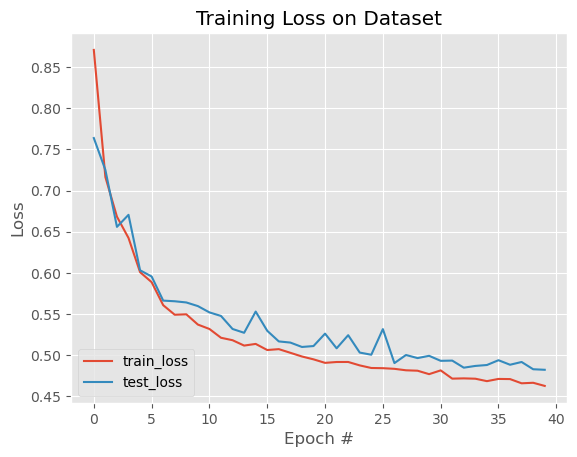

In [15]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)


In [16]:
# USAGE
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()
    

In [17]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (128, 128))
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
        filename = (imagePath.split(os.path.sep)[-1])[:12] + "_segmentation.png"
        groundTruthPath = os.path.join(MASK_DATASET_PATH,filename)
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, 0)
        gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, INPUT_IMAGE_HEIGHT))
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > THRESHOLD) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)
    

[INFO] loading up test image paths...
[INFO] load up model...
ham1000-segmentation-and-classification/images/ISIC_0025849.jpg


/var/folders/8m/1npctfws7dnc_lbx3mhg9kdc0000gn/T/ipykernel_4415/2887377380.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


ham1000-segmentation-and-classification/images/ISIC_0024892.jpg
ham1000-segmentation-and-classification/images/ISIC_0031647.jpg
ham1000-segmentation-and-classification/images/ISIC_0028185.jpg
ham1000-segmentation-and-classification/images/ISIC_0034285.jpg
ham1000-segmentation-and-classification/images/ISIC_0028387.jpg
ham1000-segmentation-and-classification/images/ISIC_0027349.jpg
ham1000-segmentation-and-classification/images/ISIC_0033711.jpg
ham1000-segmentation-and-classification/images/ISIC_0032339.jpg
ham1000-segmentation-and-classification/images/ISIC_0029458.jpg


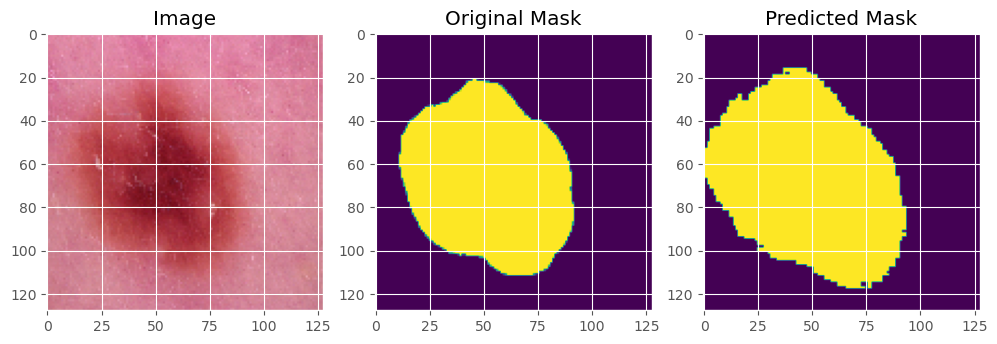

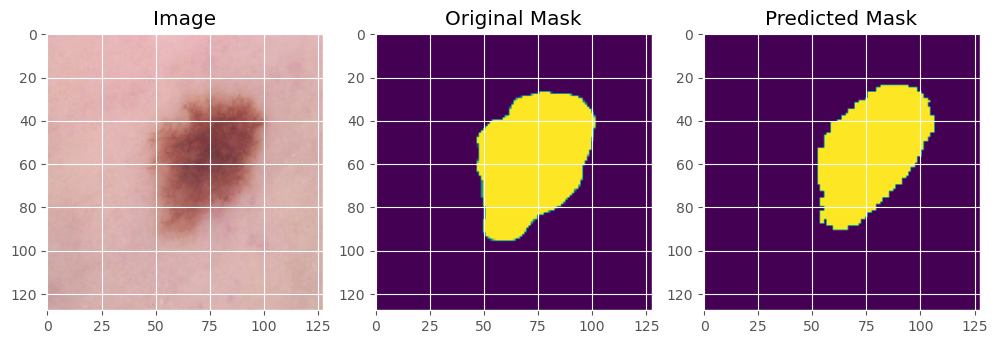

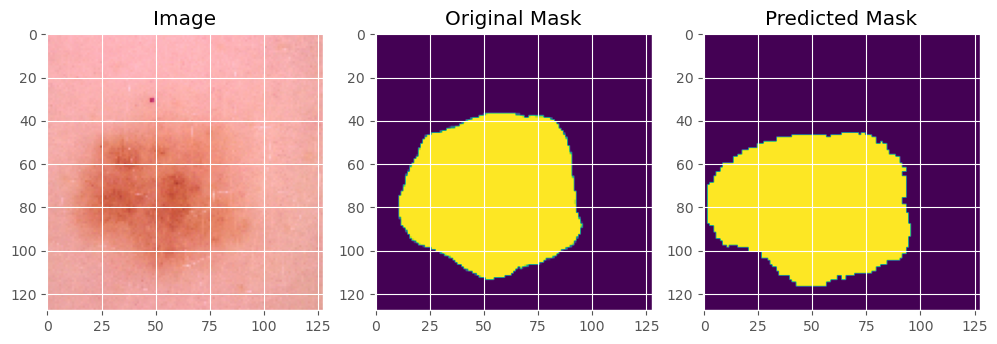

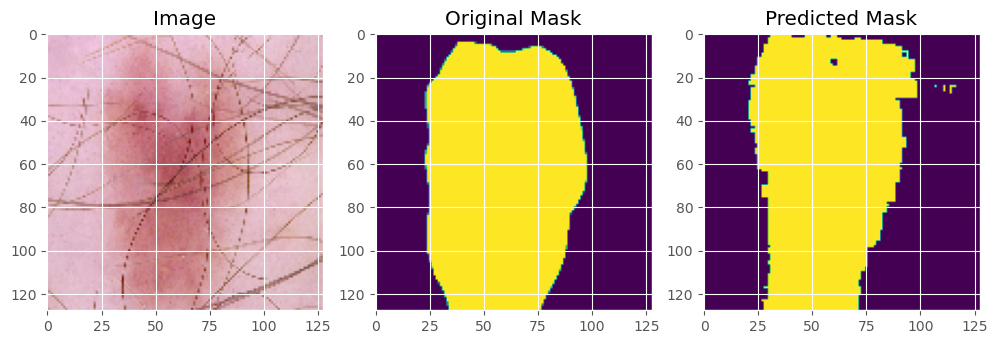

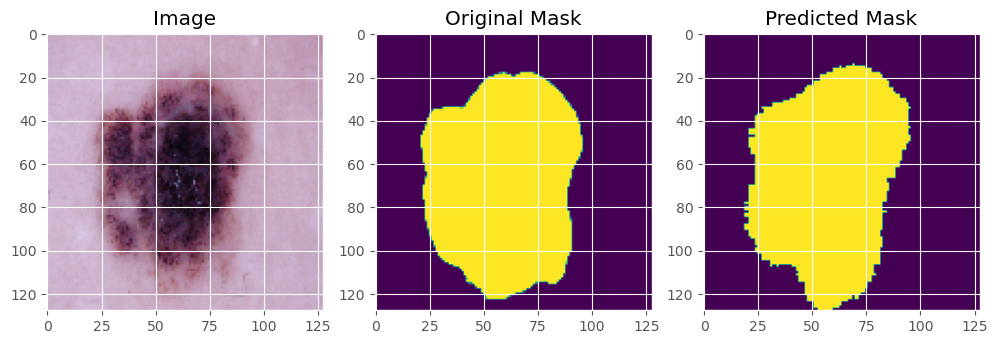

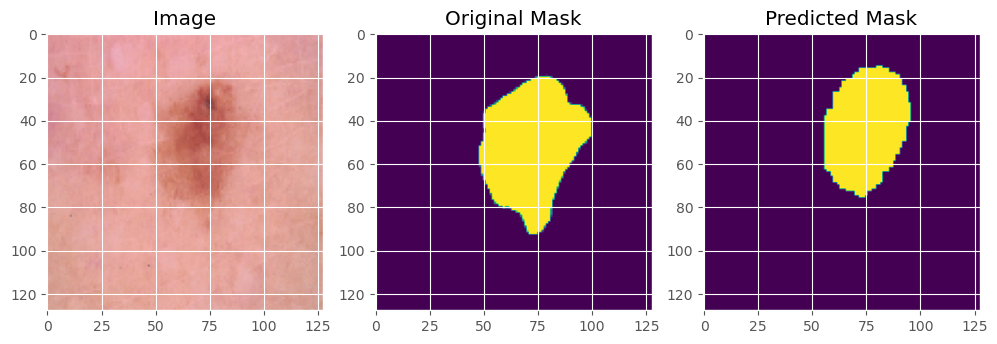

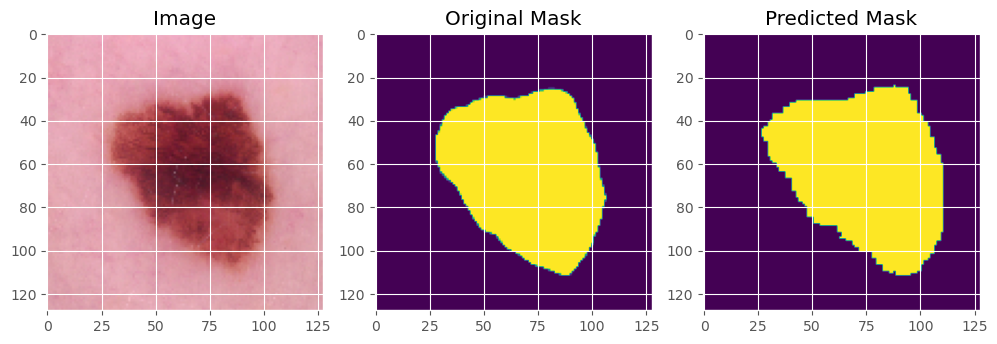

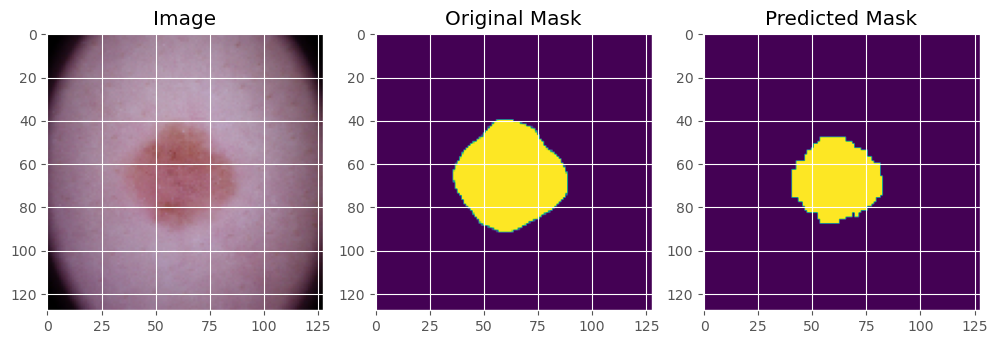

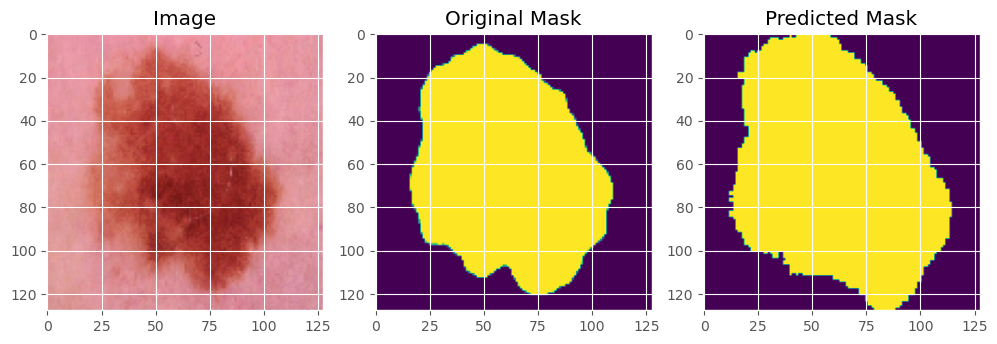

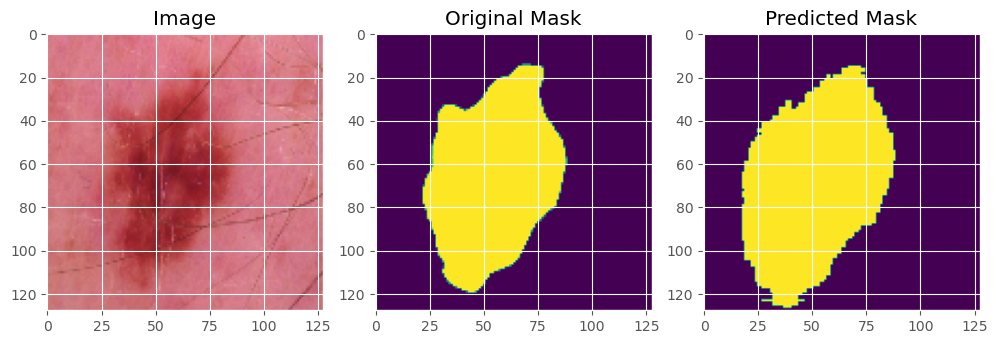

In [18]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    print(path)
    make_predictions(unet, path)
    